In [471]:
 # imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop, utils
from snntorch import functional as SF
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

from IPython.display import clear_output

from m3tqdm import tqdm
from itertools import product
import logging
import pathlib
import json

In [472]:
logging_format = '%(funcName)s [LINE:%(lineno)d]# %(levelname)-8s [%(asctime)s] %(name)s: %(message)s'

logging.basicConfig(
    format=logging_format,
    level=logging.INFO,
)

logger = logging.getLogger()

logger.handlers = logger.handlers[:1]

stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)
stream_handler.setFormatter(logging.Formatter(logging_format))

file_handler = logging.FileHandler(filename='info.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter(logging_format))

logger.addHandler(stream_handler)
logger.addHandler(file_handler)

logs_dir = pathlib.Path('logs')
logs_dir.mkdir(exist_ok=True)

data_dir = pathlib.Path('data')
data_dir.mkdir(exist_ok=True)

logger.handlers

[<FileHandler /home/sirius/m3/raai_neuro_summer_2022/project/logs.log (NOTSET)>,
 <StreamHandler stderr (INFO)>,
 <FileHandler /home/sirius/m3/raai_neuro_summer_2022/project/info.log (INFO)>]

In [473]:
batch_size = 128

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [474]:
def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(num_steps):
        res = net(data)
        spk_out, mem_out = res[0], res[-1]
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)

    return torch.stack(spk_rec), torch.stack(mem_rec)

In [475]:
def batch_accuracy(loader, net, num_steps):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()

        loader = iter(loader)
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec, _ = forward_pass(net, num_steps, data)

            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc/total

In [476]:
def get_random_acc(loader):
    total = 0
    acc = 0

    loader = iter(loader)
    for data, targets in loader:
        random_data = (np.random.uniform(size=data.size(0)) > 0.5).astype(int)
        acc += (random_data == targets.numpy()).sum()
        total += targets.size(0)

    return acc / total

In [477]:
def get_momentum_acc(loader):
    total = 0
    acc = 0

    loader = iter(loader)
    for data, close, targets in loader:
        momentum_data = np.array(list((map(lambda x: int(x[-1] > x[-2]), close))))
        acc += (momentum_data == targets.numpy()).sum()
        total += targets.size(0)
        
    return acc / total

In [478]:
def learn(net, train_loader, test_loader, num_steps=50, device=device, num_epochs=25, show_res=True, need_plot=True, logger=None, filename=None):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
    loss_fn = SF.ce_rate_loss()
    train_acc_hist = []
    test_acc_hist = []
    loss_hist = []
    
    if logger is None:
        logger = logging.getLogger(filename)
        logger.handlers = logger.handlers[:1]
        
        if filename:
            file_handler = logging.FileHandler(filename=logs_dir / f'{filename}.log')
            file_handler.setLevel(logging.INFO)
            file_handler.setFormatter(logging.Formatter(logging_format))
            logger.addHandler(file_handler)

    # training loop
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        net.train()
        avg_loss = backprop.BPTT(net, train_loader, optimizer=optimizer, criterion=loss_fn,
                                 num_steps=num_steps, time_var=False, device=device)
        loss_hist.append(float(avg_loss.cpu().detach().numpy()[0]))

        # Train set accuracy
        train_acc = batch_accuracy(train_loader, net, num_steps)
        train_acc_hist.append(train_acc)

        # Test set accuracy
        test_acc = batch_accuracy(test_loader, net, num_steps)
        test_acc_hist.append(test_acc)

        if need_plot and (epoch + 1) % 10 == 0:
            logger.info(f"Epoch {epoch + 1}, Train Loss: {avg_loss.item():.3f}")
            logger.info(f"Epoch {epoch + 1}, Train/Test Acc: {train_acc * 100:.2f}%/{test_acc * 100:.2f}%\n")
            
            if need_plot:
                clear_output()
                # Plot Loss
                fig = plt.figure(facecolor="w", figsize=(10, 5))
                plt.plot(loss_hist)
                plt.plot([])
                plt.title("Loss Curves")
                plt.legend(["Train Loss", "Test Loss"])
                plt.xlabel("Iteration")
                plt.ylabel("Loss")
                plt.show()

                fig = plt.figure(facecolor="w", figsize=(10, 5))
                plt.plot(train_acc_hist)
                plt.plot(test_acc_hist)
                plt.title("Acc Curves")
                plt.legend(["Train Acc", "Test Acc"])
                plt.xlabel("Iteration")
                plt.ylabel("Acc")
                plt.show()

                if show_res:
                    plot_res(net)
                    plot_res(net, 'train')
    
    if filename:
        fig = plt.figure(facecolor="w", figsize=(10, 5))
        plt.plot(loss_hist)
        plt.plot([])
        plt.title("Loss Curves")
        plt.legend(["Train Loss", "Test Loss"])
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.savefig(data_dir / f'{filename}-loss.png')
        plt.close()

        fig = plt.figure(facecolor="w", figsize=(10, 5))
        plt.plot(train_acc_hist)
        plt.plot(test_acc_hist)
        plt.title("Acc Curves")
        plt.legend(["Train Acc", "Test Acc"])
        plt.xlabel("Iteration")
        plt.ylabel("Acc")
        plt.savefig(data_dir / f'{filename}-acc.png')
        plt.close()
        
        plot_res(net, filename=filename + '-test')
        plot_res(net, 'train', filename=filename + '-train')
        
    model_acc = batch_accuracy(train_loader, net, num_steps)
    random_acc = sum([get_random_acc(train_loader) for _ in range(10)]) / 10
    momentum_acc = get_momentum_acc(train_loader_close)
    
    logger.info('Train diff')
    logger.info('Model acc:\t\t%s', model_acc)
    logger.info('Random acc (mean 10):\t%s', random_acc)
    logger.info('Momentum acc:\t\t%s', momentum_acc)
    
    model_acc = batch_accuracy(test_loader, net, num_steps)
    random_acc = sum([get_random_acc(test_loader) for _ in range(10)]) / 10
    momentum_acc = get_momentum_acc(test_loader_close)
    
    logger.info('Test diff')
    logger.info('Model acc:\t\t%s', model_acc)
    logger.info('Random acc (mean 10):\t%s', random_acc)
    logger.info('Momentum acc:\t\t%s', momentum_acc)
    
    
    return train_acc_hist, test_acc_hist, loss_hist

In [479]:
def plot_res(net, plot_type='test', delim=None, filename=None):
    x = test_x if plot_type == 'test' else train_x
    y = test_y if plot_type == 'test' else train_y
    
    dataset = test_dataset if plot_type == 'test' else train_dataset
    skip = int(x.size / delim) if delim else 1
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=True)
    res_up = []
    res_down = []
    right = 0
    all = 0
    net.eval()
    printed = False
    for data, target in loader:
        res = net(data.to(device))
        output = res[0]
        if output.sum() > 0 and not printed:
            printed = True
            # print(res[1][0])
            # print(output.sum(dim=0))
        _, idx = output.sum(dim=0).max(0)
        idx = idx.cpu()
        if idx == 1:
            res_up.append(float(y[all + window - 1]))
            res_down.append(float('nan'))
        else:
            res_up.append(float('nan'))
            res_down.append(float(y[all + window - 1]))
        right += int(idx == target)
        all += 1
    # if not printed:
    #     print(res[1][0])
    #     print(output.sum(dim=0))
    
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(x[skip:-skip], y[skip:-skip])
    plt.scatter(x[window - 1 + skip:-1 - skip], res_up[skip:-skip], marker='^', color='green')
    plt.scatter(x[window - 1 + skip:-1 - skip], res_down[skip:-skip], marker='v', color='red')
    plt.title(f"Plot {plot_type}, Accuracy: {100 * right / all:.2f}%")
    if filename:
        plt.savefig(data_dir / f'{filename}.png')
        plt.close()
    else:
        plt.show()

In [480]:
def plot_data(x, y):
    fig = plt.figure(facecolor="w", figsize=(10, 5))
    plt.plot(x, y)
    plt.show()

In [481]:
def test_net(net, train_loader, test_loader, num_steps):
    data, targets = next(iter(train_loader))
    spk_rec, mem_rec = forward_pass(net, num_steps, data.to(device))
    print(spk_rec.shape)
    test_acc = sum([batch_accuracy(test_loader, net, num_steps) for _ in range(10)]) / 10
    print(test_acc)

In [482]:
class NetFF(nn.Module):
    def __init__(self, num_inputs, num_hidden=8, num_outputs=2, beta=0.5, threshold=1, learn_threshold=False, reset_mechanism='subtract', spike_grad=None):
        super().__init__()

        spike_grad = spike_grad or spike_grad or surrogate.fast_sigmoid(slope=25)

        self.lin1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, init_hidden=True, learn_threshold=learn_threshold, reset_mechanism=reset_mechanism)
        self.lin2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold, init_hidden=True, learn_threshold=learn_threshold, reset_mechanism=reset_mechanism, output=True)
        
    def forward(self, x):
        return self.lif2(self.lin2(self.lif1(self.lin1(x.flatten(1)))))

    
class NetLSTM(nn.Module):
    def __init__(self, num_inputs, num_hidden=8, num_outputs=2, threshold=0.5, learn_threshold=False, reset_mechanism='subtract', spike_grad=None, beta=None):
        super().__init__()

        spike_grad = spike_grad or surrogate.fast_sigmoid(25)

        self.slstm1 = snn.SLSTM(num_inputs, num_hidden, spike_grad=spike_grad, threshold=threshold, learn_threshold=learn_threshold, reset_mechanism=reset_mechanism)
        self.slstm2 = snn.SLSTM(num_hidden, num_outputs, spike_grad=spike_grad, threshold=threshold, learn_threshold=learn_threshold, output=True, reset_mechanism=reset_mechanism)

    def forward(self, x):
        mem, syn = self.slstm1.init_slstm()
        out, mem, syn = self.slstm1(x.flatten(1), syn=syn, mem=mem)
        
        mem, syn = self.slstm2.init_slstm()
        out, mem, syn = self.slstm2(out, syn=syn, mem=mem)
        return out, mem, syn

In [483]:
def model_getter(model_type='NetFF', **kwargs):
    if model_type == 'NetFF':
        return NetFF(**kwargs).to(device)
    elif model_type == 'NetLSTM':
        return NetLSTM(**kwargs).to(device)
    else:
        raise NotImplementedError()

# Simple ThrData 
x>0.5 or x<0.5

In [11]:
class ThrDataset(Dataset):
    def __init__(self, data, thr):
        self.data = data
        self.thr = thr

    def __getitem__(self, index):
        return torch.tensor([self.data[index]]).float(), int(self.data[index] > self.thr)

    def __len__(self):
        return len(self.data)

In [12]:
train_data = np.random.uniform(size=1000)
test_data = np.random.uniform(size=1000)

train_dataset = ThrDataset(data=train_data, thr=0.5)
test_dataset =  ThrDataset(data=test_data, thr=0.5)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
data, targets = next(iter(train_loader))

## One neuron

Epoch 50, Train Loss: 0.420585
Epoch 50, Train/Test Acc: 98.88%/98.21%



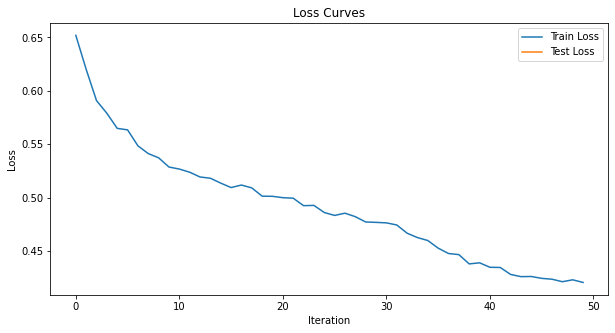

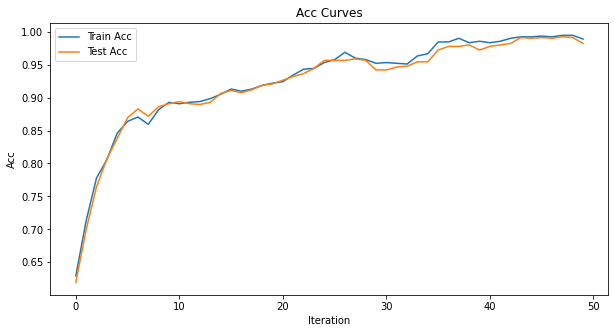

In [15]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs=2, beta=0.5):
        super().__init__()

        spike_grad = surrogate.fast_sigmoid(slope=25)

        self.lin = nn.Linear(num_inputs, num_outputs)
        self.lif = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

    def forward(self, x):
        return self.lif(self.lin(x.flatten(1)))

net = Net(num_inputs=1).to(device)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=50, show_res=False)

## One slstm

Epoch 50, Train Loss: 0.327962
Epoch 50, Train/Test Acc: 99.11%/99.11%



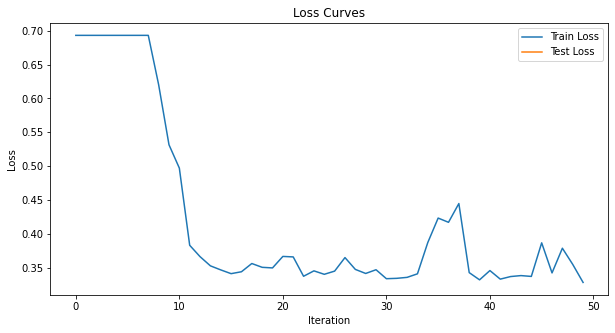

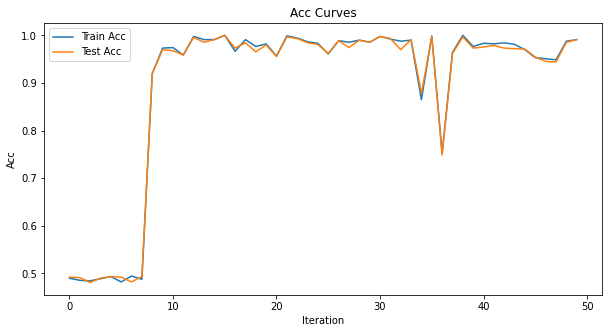

In [17]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs=2):
        super().__init__()

        spike_grad = surrogate.straight_through_estimator()

        self.slstm1 = snn.SLSTM(num_inputs, num_outputs, spike_grad=spike_grad, init_hidden=True, output=True, threshold=0.5)

    def forward(self, x):
        return self.slstm1(x.flatten(1))

net = Net(num_inputs=1).to(device)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=50, show_res=False)

# WindowDataset
Up or Down

In [18]:
window = 10

In [19]:
class WindowDataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        return x, int(self.data[index+self.window] > x[-1])

    def __len__(self):
        return len(self.data) - self.window

## sin

In [20]:
def f_sin(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return torch.sin(x).float()

## sin 3x...


In [21]:
def f_sin3x(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (0.5 * torch.sin(3 * x) + 0.5 * torch.sin(6 * x) + 1).float()

## sin with noise

In [22]:
def f_sin_noise(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (f_sin3x(x) + 0.1 * torch.rand(x.size(0))).float()

## sin with trend

In [23]:
def f_sin_trend(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (f_sin(x) + 0.001 * np.arange(x.size(0))).float()

## sin3x trend

In [24]:
def f_sin3x_trend(x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    return (f_sin3x(x) + 0.005 * np.arange(x.size(0))).float()

In [39]:
f = f_sin3x_trend

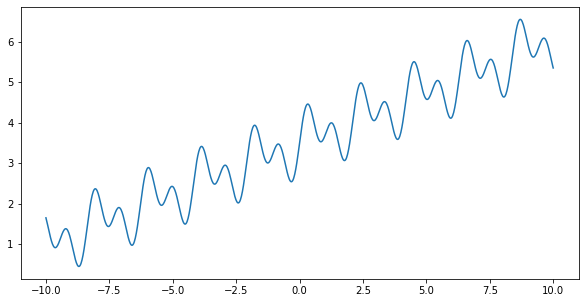

In [40]:
train_x = np.linspace(-10, 10, 1000)
test_x = np.linspace(-10, 10, 1000)
train_y = f(train_x)
test_y = f(test_x)

train_dataset = WindowDataset(data=train_y, window=window)
test_dataset =  WindowDataset(data=test_y, window=window)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
plot_data(train_x, f(train_x))

Epoch 50, Train Loss: 0.493021
Epoch 50, Train/Test Acc: 84.26%/83.37%



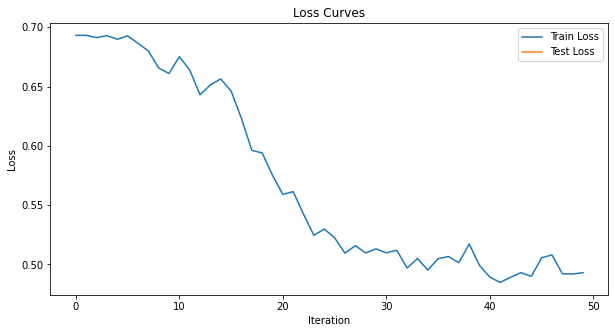

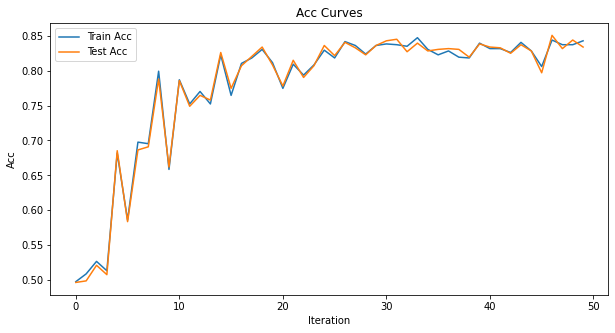

tensor([ 3.0657, -0.7781], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([107.,   5.], device='cuda:0', grad_fn=<SumBackward1>)


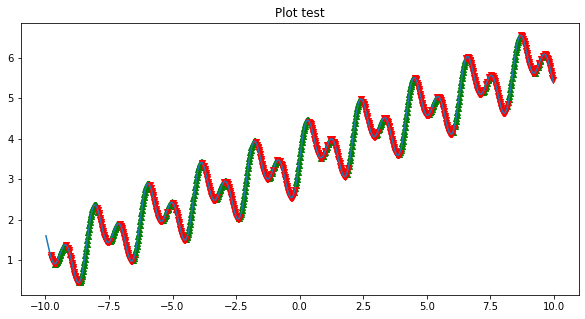

Accuracy: 82.73%
tensor([ 3.4395, -2.4268], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([128.,   0.], device='cuda:0', grad_fn=<SumBackward1>)


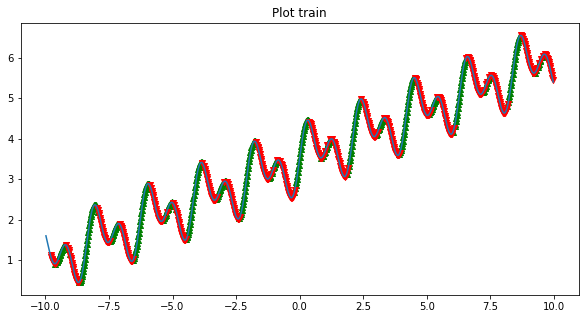

Accuracy: 82.63%


In [32]:
net = model_getter('NetFF', num_inputs=window, num_hidden=16)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=50)

Epoch 50, Train Loss: 0.468396
Epoch 50, Train/Test Acc: 85.60%/85.60%



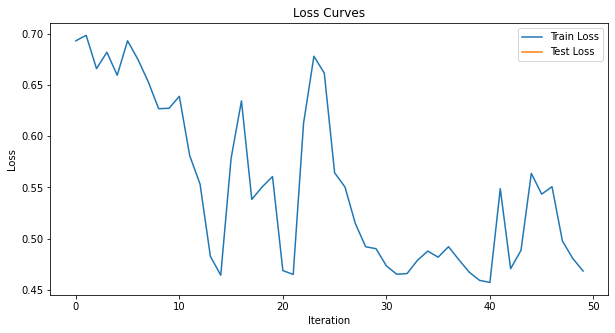

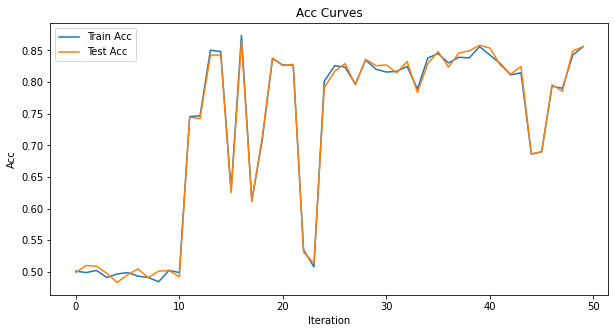

tensor([ 0.9336, -0.2197], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 0.], device='cuda:0', grad_fn=<SumBackward1>)


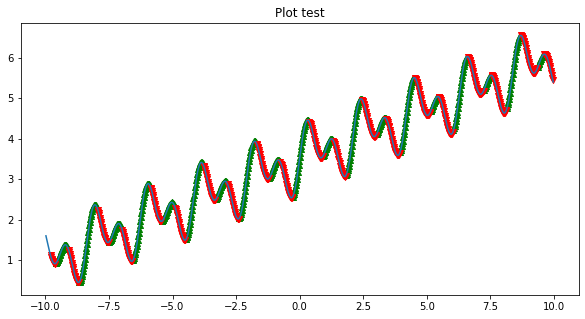

Accuracy: 85.76%
tensor([ 0.9336, -0.2197], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 0.], device='cuda:0', grad_fn=<SumBackward1>)


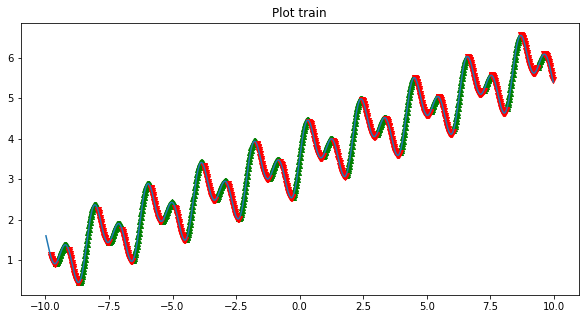

Accuracy: 85.76%


In [46]:
net = model_getter('NetLSTM', num_inputs=window, num_hidden=16)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=50)

# WindowsStockDataset

In [364]:
window = 10

In [365]:
class WindowStockDataset(Dataset):
    def __init__(self, data, close_data, window, return_close=False):
        self.data = data
        self.close_data = close_data
        self.window = window
        self.return_close = return_close

    def __getitem__(self, index):
        price_data = self.data.iloc[
            index : index+self.window
        ].values
        price_data = np.array(price_data).ravel().reshape(-1).astype(np.float32)
        
        close_data = self.close_data[
            index : index+self.window
        ]
        close_data = np.array(close_data).ravel().reshape(-1).astype(np.float32)
        
        if self.return_close:
            return price_data, close_data, int(self.close_data[index+self.window] > self.close_data[index+self.window-1])
        return price_data, int(self.close_data[index+self.window] > self.close_data[index+self.window-1])
        
    def __len__(self):
        return len(self.data) - self.window

In [366]:
import datetime as dt
from dataloader import DataLoader as m3DataLoader
from signals import macd, rsi

dataloader = m3DataLoader()
train_data = dataloader.get_data_less_day(
    'TCS',
    dt.datetime(2020, 1, 1),
    dt.datetime(2021, 1, 1),
    interval='1d',
)
train_data['macd'], train_data['macd_signal'] = macd(train_data.close)
train_data['macd_hist'] = train_data['macd'] - train_data['macd_signal']
train_data['rsi'] = rsi(train_data.close)
train_x = train_data.close.index
train_y = train_data.close.values
train_data = train_data[['macd_hist']]

test_data = dataloader.get_data_less_day(
    'TCS',
    dt.datetime(2021, 2,22),
    dt.datetime(2022, 2, 22),
    interval='1d',
)
test_data['macd'], test_data['macd_signal'] = macd(test_data.close)
test_data['macd_hist'] = test_data['macd'] - test_data['macd_signal']
test_data['rsi'] = rsi(test_data.close)
test_x = test_data.close.index
test_y = test_data.close.values
test_data = test_data[['macd_hist']]

DataLoader tinkoff created
__init__ [LINE:68]# INFO     [2022-07-16 10:47:46,494] dataloader: DataLoader tinkoff created
Getting TCS for 1 years (2020-01-01 00:00:00 - 2021-01-01 00:00:00)
get_data_less_day [LINE:160]# INFO     [2022-07-16 10:47:46,495] dataloader: Getting TCS for 1 years (2020-01-01 00:00:00 - 2021-01-01 00:00:00)
get [LINE:45]# INFO     [2022-07-16 10:47:46,498] m3_tinkoff_client.candles_cache: Loaded from cache
Getting TCS for 1 years (2021-02-22 00:00:00 - 2022-02-22 00:00:00)
get_data_less_day [LINE:160]# INFO     [2022-07-16 10:47:46,506] dataloader: Getting TCS for 1 years (2021-02-22 00:00:00 - 2022-02-22 00:00:00)
get [LINE:45]# INFO     [2022-07-16 10:47:46,507] m3_tinkoff_client.candles_cache: Loaded from cache


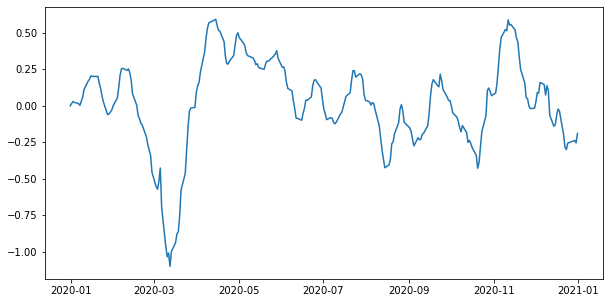

In [367]:
train_dataset = WindowStockDataset(train_data, train_y, window)
train_dataset_close = WindowStockDataset(train_data, train_y, window, return_close=True)
test_dataset = WindowStockDataset(test_data, test_y, window)
test_dataset_close = WindowStockDataset(test_data, test_y, window, return_close=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader_close = DataLoader(train_dataset_close, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_close = DataLoader(test_dataset_close, batch_size=batch_size, shuffle=False, drop_last=True)
data, targets = next(iter(train_loader))  # test all ok
plot_data(train_data.index, train_data.values)

In [340]:
# соотношение вверх/вниз
# Сравнение со случайным
# сравнение с правилом "куда последнее"

Epoch 500, Train Loss: 0.646852
Epoch 500, Train/Test Acc: 66.41%/51.56%



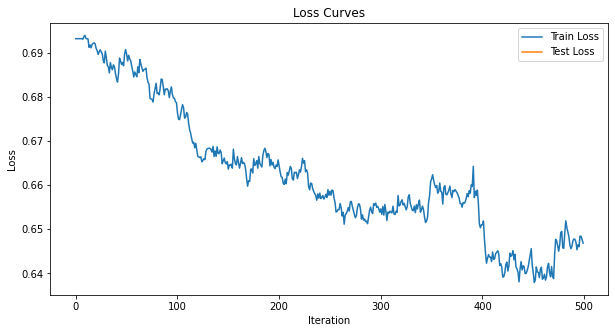

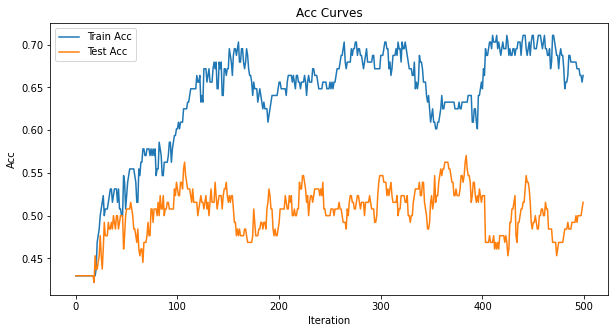

tensor([-0.0572,  0.1346], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([31., 43.], device='cuda:0', grad_fn=<SumBackward1>)


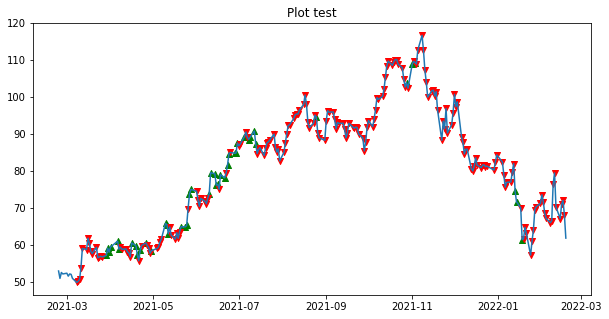

Accuracy: 45.68%
tensor([-0.2292,  3.6114], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([  0., 128.], device='cuda:0', grad_fn=<SumBackward1>)


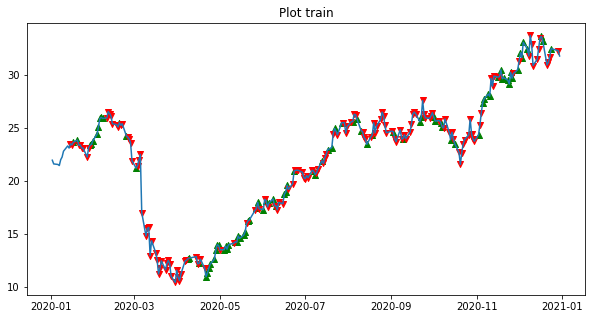

Accuracy: 53.06%


In [51]:
net = model_getter('NetFF', num_inputs=window, num_hidden=16)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=500)

Epoch 500, Train Loss: 0.569153
Epoch 500, Train/Test Acc: 73.44%/48.44%



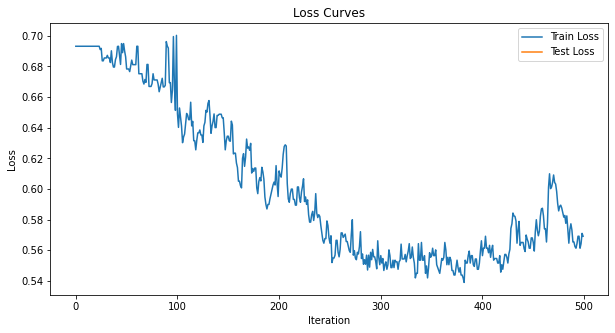

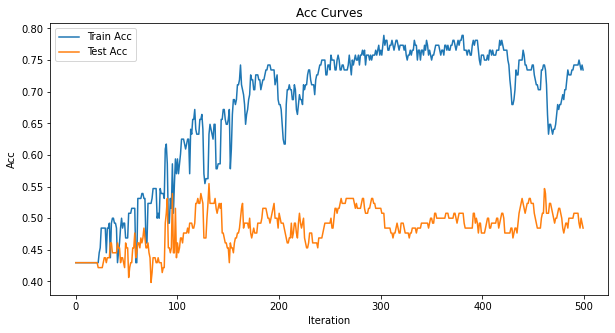

tensor([ 0.7000, -0.0622], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1., 0.], device='cuda:0', grad_fn=<SumBackward1>)


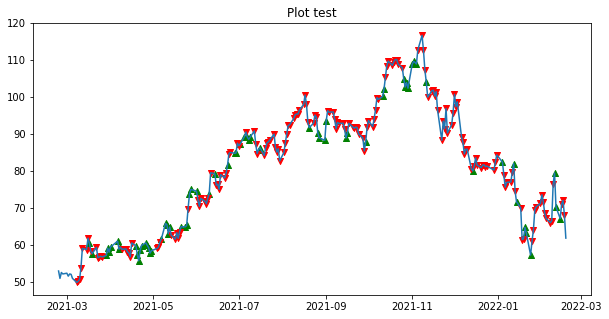

Accuracy: 48.97%
tensor([-0.0236,  0.8319], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0., 1.], device='cuda:0', grad_fn=<SumBackward1>)


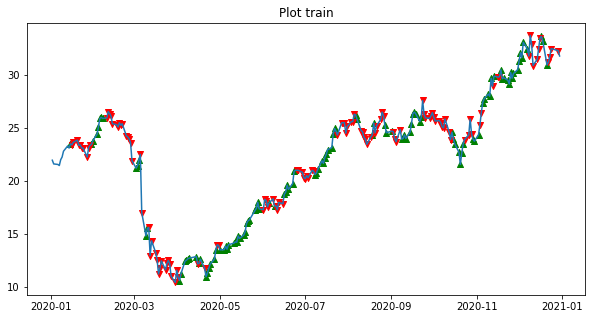

Accuracy: 62.86%


In [52]:
net = model_getter('NetLSTM', num_inputs=window, num_hidden=16)
learn(net, train_loader, test_loader, num_steps=50, num_epochs=500)

In [484]:
model_parameters_product = {
    'model_name': ['NetFF', 'NetLSTM'],
    'num_hidden': [8, 16, 32],
    'threshold': np.linspace(0.1, 0.5, 3),
    'learn_threshold': [False, True],
    'reset_mechanism': ['none', 'zero', 'subtract'],
    'spike_grad_rate': [25, 10],
}
env_parameters_product = {
    'num_steps': [50],
}

In [1]:
print(f'Running on {device}')
best_test_acc = 0
best_name = None
for env_param in tqdm(list(product(*env_parameters_product.values()))[::-1], name='env_param', logger=logger):
    for model_param in tqdm(list(product(*model_parameters_product.values()))[::-1], name='model_param', logger=logger):
        num_steps, = env_param
        model_name, num_hidden, threshold, learn_threshold, reset_mechanism, spike_grad_rate = model_param
        spike_grad_func = surrogate.fast_sigmoid(spike_grad_rate)
        beta_range = np.linspace(0.5, 0.9, 3) if model_name == 'NetFF' else [None]
        for beta in beta_range:
            filename = f'num_steps={num_steps}-model_name={model_name}-num_hidden={num_hidden}-threshold={threshold}-learn_threshold={learn_threshold}-reset_mechanism={reset_mechanism}-spike_grad_rate={spike_grad_rate}-beta={beta}'
            logger.info('Parameters: %s', filename)
            net = model_getter(model_name, num_inputs=window, num_hidden=num_hidden, threshold=threshold, learn_threshold=learn_threshold, reset_mechanism=reset_mechanism, spike_grad=spike_grad)
            train_acc_hist, test_acc_hist, loss_hist = learn(net, train_loader, test_loader, num_steps=num_steps, num_epochs=300, need_plot=False, filename=filename)
            with open(logs_dir / f'{filename}.json', 'w') as f:
                json.dump({
                    'train_acc_hist': train_acc_hist,
                    'test_acc_hist': test_acc_hist,
                    'loss_hist': loss_hist,
                }, f)
            if test_acc_hist[-1] > best_test_acc:
                best_test_acc = test_acc_hist[-1]
                best_name = filename
                logger.warning('NEW BEST (acc %s): %s', best_test_acc, best_name)

In [ ]:
logger.info('BEST (acc %s): %s', best_test_acc, best_name)

In [ ]:
# WARNING  [2022-07-16 12:25:56,142] root: NEW BEST (acc 0.5703125): num_steps=50-model_name=NetLSTM-num_hidden=16-threshold=0.1-learn_threshold=False-reset_mechanism=zero-spike_grad_rate=25-beta=None
# WARNING  [2022-07-16 13:37:26,248] root: NEW BEST (acc 0.5859375): num_steps=50-model_name=NetFF  -num_hidden=32-threshold=0.3-learn_threshold=False-reset_mechanism=none-spike_grad_rate=25-beta=0.9